## Project Objective is to build a classifier to predict the Pass/Fail yield of a particular process entity and analyse whether all the features are required to build the model or not.

###### Import Some Basic Libraries

In [373]:
# for basic operations
import numpy as np 
import pandas as pd 

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# for modeling 
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.svm import OneClassSVM

# to avoid warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Reading the Data and understanding the attributes

###### Q1 A - Import ‘signal-data.csv’ as DataFrame.

In [374]:
#Reading the Data and understanding the attributes
data = pd.read_csv('signal_data.csv')

# getting the shape of the data
# we have 1,567 rows and 592 columns
print(data.shape)

(1567, 592)


In [375]:
data.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [376]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


###### Q1 B - Print 5 point summary and share at least 2 observations

In [377]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Time,1567,1534,2008-10-15 01:52:00,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1561.0,NaN,NaN,NaN,3014.452896,73.621787,2743.24,2966.26,3011.49,3056.65,3356.35
1,1560.0,NaN,NaN,NaN,2495.850231,80.407705,2158.75,2452.2475,2499.405,2538.8225,2846.44
2,1553.0,NaN,NaN,NaN,2200.547318,29.513152,2060.66,2181.0444,2201.0667,2218.0555,2315.2667
3,1553.0,NaN,NaN,NaN,1396.376627,441.69164,0.0,1081.8758,1285.2144,1591.2235,3715.0417
...,...,...,...,...,...,...,...,...,...,...,...
586,1566.0,NaN,NaN,NaN,0.021458,0.012358,-0.0169,0.013425,0.0205,0.0276,0.1028
587,1566.0,NaN,NaN,NaN,0.016475,0.008808,0.0032,0.0106,0.0148,0.0203,0.0799
588,1566.0,NaN,NaN,NaN,0.005283,0.002867,0.001,0.0033,0.0046,0.0064,0.0286
589,1566.0,NaN,NaN,NaN,99.670066,93.891919,0.0,44.3686,71.9005,114.7497,737.3048


###### Observation: 
1. The pass rate is higher than the fail rate as the negative value of pass/fail in the mean column indicates pass rates are higher for this system.

2.  The values in the count column is same all over in the data.

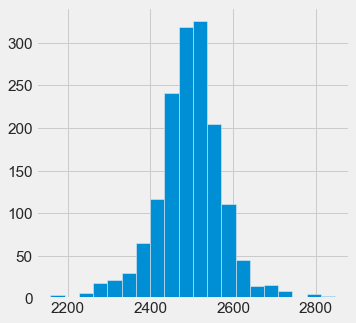

In [378]:
plt.hist(data['1'],bins=20);

C:\Users\dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


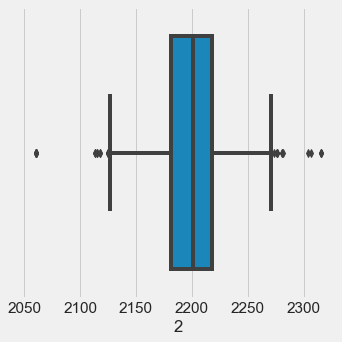

In [379]:
sns.boxplot(data['2']);

### Data Cleaning

###### Q2 A - Write a for loop which will remove all the features with 20%+ Null values and impute rest with mean of the feature

In [380]:
data.isnull().any().any()

True

In [381]:
data.dtypes

Time          object
0            float64
1            float64
2            float64
3            float64
              ...   
586          float64
587          float64
588          float64
589          float64
Pass/Fail      int64
Length: 592, dtype: object

In [382]:
dft= data.drop(['Time'], axis=1)

In [383]:
#check Percentage of missing values
dft.isnull().sum() * 100 / len(data)

0            0.382897
1            0.446713
2            0.893427
3            0.893427
4            0.893427
               ...   
586          0.063816
587          0.063816
588          0.063816
589          0.063816
Pass/Fail    0.000000
Length: 591, dtype: float64

In [384]:
#looping for imputing missing values
for col in dft.columns:
 if dft[col].isnull().sum()/len(dft) >= 0.2:
   dft.drop(col, axis=1, inplace=True)

 else:
   dft[col].fillna(dft[col].mean(), inplace=True)

In [385]:
dft.isnull().any().any()

False

###### Q2 B - Identify and drop the features which are having same value for all the rows.

In [386]:
unique_columns = dft.nunique()
drop_columns = unique_columns[unique_columns == 1].index
dft.drop(drop_columns, axis=1)

,0,1,2,3,4,6,7,8,9,10,...,577,582,583,584,585,586,587,588,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.500500,0.016200,-0.003400,...,14.9509,0.5005,0.0118,0.0035,2.3630,0.021458,0.016475,0.005283,99.670066,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.496600,-0.000500,-0.014800,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.009600,0.020100,0.006000,208.204500,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.443600,0.004100,0.001300,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.058400,0.048400,0.014800,82.860200,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.488200,-0.012400,-0.003300,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.020200,0.014900,0.004400,73.843200,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.503100,-0.003100,-0.007200,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.020200,0.014900,0.004400,73.843200,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,82.2467,0.1248,1.342400,-0.004500,-0.005700,...,11.7256,0.4988,0.0143,0.0039,2.8669,0.006800,0.013800,0.004700,203.172000,-1
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,98.4689,0.1205,1.433300,-0.006100,-0.009300,...,17.8379,0.4975,0.0131,0.0036,2.6238,0.006800,0.013800,0.004700,203.172000,-1
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,99.4122,0.1208,1.462862,-0.000841,0.000146,...,17.7267,0.4987,0.0153,0.0041,3.0590,0.019700,0.008600,0.002500,43.523100,-1
1565,2894.92,2532.01,2177.0333,1183.7287,1.5726,98.7978,0.1213,1.462200,-0.007200,0.003200,...,19.2104,0.5004,0.0178,0.0038,3.5662,0.026200,0.024500,0.007500,93.494100,-1


###### Q2 C - Drop other features if required using relevant functional knowledge. Clearly justify the same.

    The Time column was previously removed because it contained object values. There will be no other changes.

In [387]:
dft.dtypes

0            float64
1            float64
2            float64
3            float64
4            float64
              ...   
586          float64
587          float64
588          float64
589          float64
Pass/Fail      int64
Length: 559, dtype: object

In [388]:
#Checking for missing data
dft.isnull().sum()

0            0
1            0
2            0
3            0
4            0
            ..
586          0
587          0
588          0
589          0
Pass/Fail    0
Length: 559, dtype: int64

In [389]:
#Creating training data
X = dft.drop(['Pass/Fail'], axis=1)
Y = dft['Pass/Fail']

In [390]:
X.shape, Y.shape

((1567, 558), (1567,))

In [394]:
#The linear regression model
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
sfs_1 = sfs(lr, k_features=4, forward=True, verbose=2, scoring='neg_mean_squared_error')

In [395]:
#Fitting the data
sfs_1 = sfs_1.fit(X, Y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 558 out of 558 | elapsed:    2.6s finished

[2022-12-11 20:05:46] Features: 1/4 -- score: -0.24341404167613456[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 557 out of 557 | elapsed:    2.7s finished

[2022-12-11 20:05:49] Features: 2/4 -- score: -0.24037890665025582[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 556 out of 556 | elapsed:    2.8s finished

[2022-12-11 20:05:52] Features: 3/4 -- score: -0.23758755325860462[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Don

In [396]:
ft_names = list(sfs_1.k_feature_names_)
print(ft_names)

['21', '59', '64', '103']


In [397]:
# We will create a new dataframe using the variables obtained and adding the target variable
df_new = dft[ft_names]

df_new.head()

,21,59,64,103
0,-5419.00,-1.7264,21.7264,-0.0042
1,-5441.50,0.8073,19.1927,-0.0045
2,-5447.75,23.8245,16.1755,-0.0026
3,-5468.25,24.3791,15.6209,-0.0059
4,-5476.25,-12.2945,32.2945,-0.0045


In [398]:
dft.dtypes

0            float64
1            float64
2            float64
3            float64
4            float64
              ...   
586          float64
587          float64
588          float64
589          float64
Pass/Fail      int64
Length: 559, dtype: object

### Data analysis & visualisation

###### Q3 A - Perform a detailed univariate Analysis with appropriate detailed comments after each analysis.

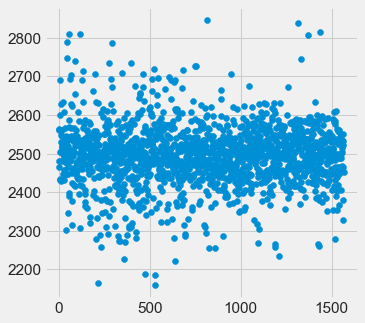

In [399]:
plt.scatter(dft.index,dft['1'])
plt.show()

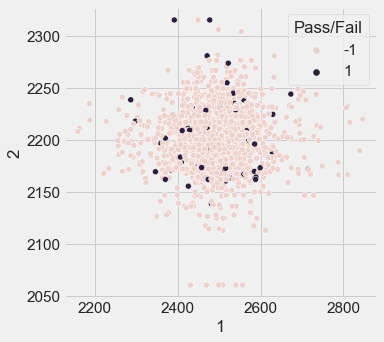

In [400]:
#scatterplot
sns.scatterplot(x=dft['1'],y=dft['2'],hue=dft['Pass/Fail']);
#The fail count is less in this column

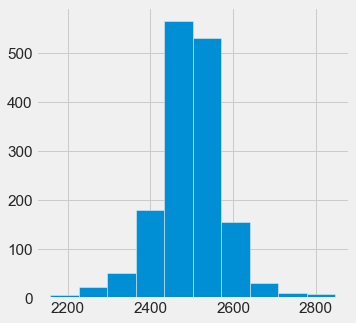

In [401]:
#sns histplot
plt.hist(dft['1']);

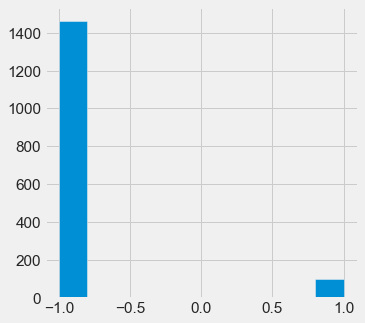

In [402]:
#histplot
plt.hist(dft['Pass/Fail']);

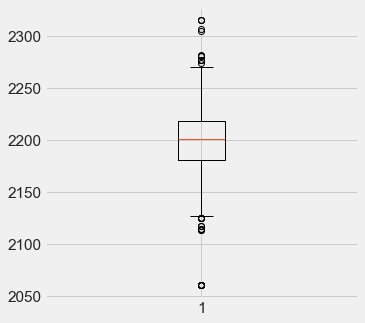

In [403]:
#boxplot
plt.boxplot(dft['2']);

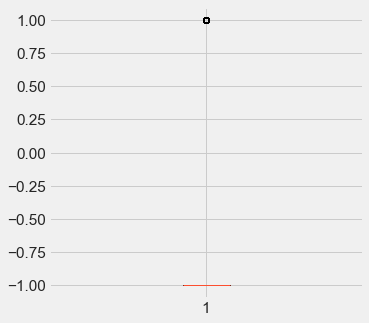

In [404]:
#box plot
plt.boxplot(dft['Pass/Fail']);

###### Comment : 
       the column Pass/Fail has only 2 values. So, the box plot has outliers on -1 and +1

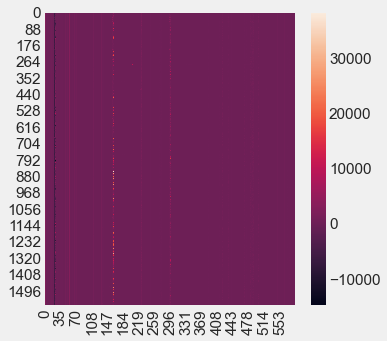

In [405]:
#heatmap
sns.heatmap(dft);

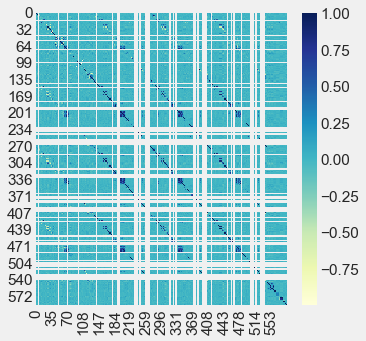

In [406]:
#correlation values
sns.heatmap(dft.corr(), cmap="YlGnBu");

###### Comment: 
      There is high correlation among the features given in the data set on both upper and lower bounds.

###### Q3 B - Perform bivariate and multivariate analysis with appropriate detailed comments after each analysis.

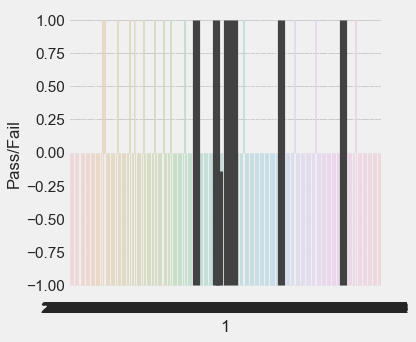

In [407]:
#Barplot
sns.barplot(x="1",y="Pass/Fail",data=dft);

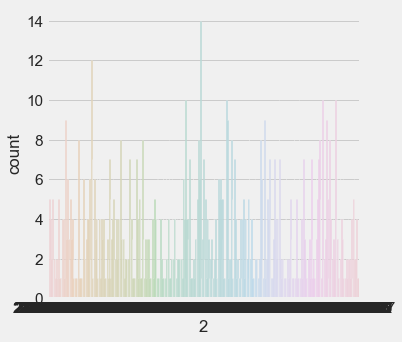

In [408]:
#Countplot
sns.countplot(x='2',data=dft);

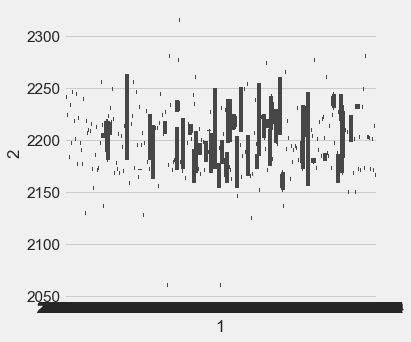

In [409]:
#boxplot for 2 columns 
sns.boxplot(x='1',y='2',data=dft,palette='rainbow');

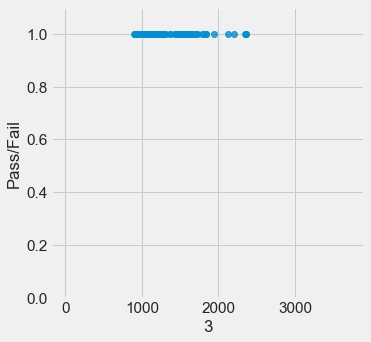

In [410]:
#Regplot
sns.regplot(x='3',y='Pass/Fail',data=dft)
plt.ylim(0,);

###### Comment: 
      Values between 1000 and 2500 have a value of 1

In [411]:
#Multivariate Analysis
x = dft.loc[:, "1":] # independent variables
y = dft['2'] #dependant variables
dft

,0,1,2,3,4,5,6,7,8,9,...,577,582,583,584,585,586,587,588,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.500500,0.016200,...,14.9509,0.5005,0.0118,0.0035,2.3630,0.021458,0.016475,0.005283,99.670066,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.496600,-0.000500,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.009600,0.020100,0.006000,208.204500,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.443600,0.004100,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.058400,0.048400,0.014800,82.860200,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.488200,-0.012400,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.020200,0.014900,0.004400,73.843200,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.503100,-0.003100,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.020200,0.014900,0.004400,73.843200,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.342400,-0.004500,...,11.7256,0.4988,0.0143,0.0039,2.8669,0.006800,0.013800,0.004700,203.172000,-1
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.433300,-0.006100,...,17.8379,0.4975,0.0131,0.0036,2.6238,0.006800,0.013800,0.004700,203.172000,-1
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,1.462862,-0.000841,...,17.7267,0.4987,0.0153,0.0041,3.0590,0.019700,0.008600,0.002500,43.523100,-1
1565,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.462200,-0.007200,...,19.2104,0.5004,0.0178,0.0038,3.5662,0.026200,0.024500,0.007500,93.494100,-1


C:\Users\dell\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:100: UserWarning: Attempting to set identical left == right == 100.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\Users\dell\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:100: UserWarning: Attempting to set identical left == right == 100.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\Users\dell\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:100: UserWarning: Attempting to set identical left == right == 100.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\Users\dell\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:100: UserWarning: Attempting to set identical left == right == 100.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\Users\dell\anaconda3\lib\

LinAlgError: singular matrix

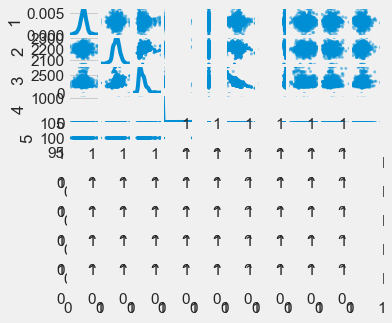

In [412]:
pd.plotting.scatter_matrix(dft.loc[:, "1":"10"], diagonal="kde")
plt.show()

C:\Users\dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\User

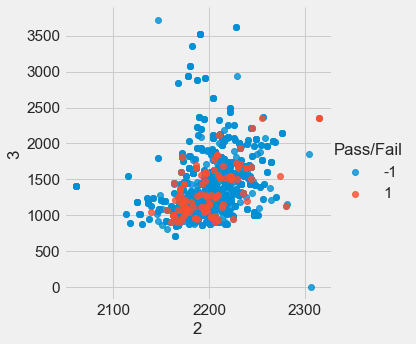

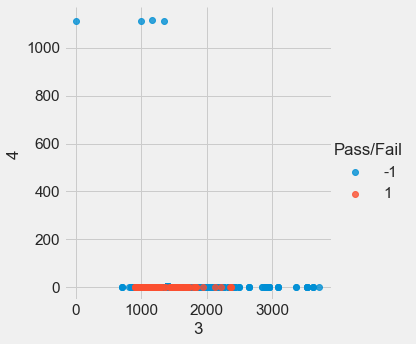

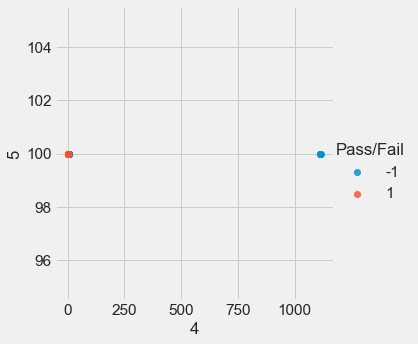

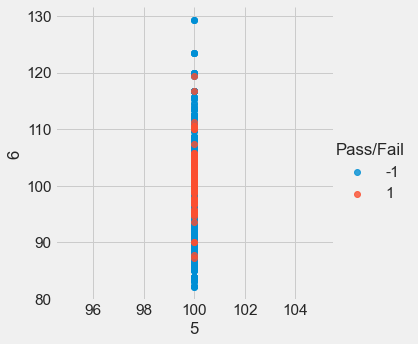

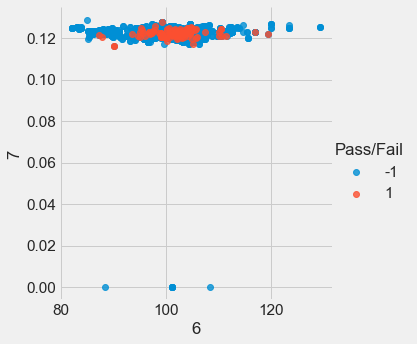

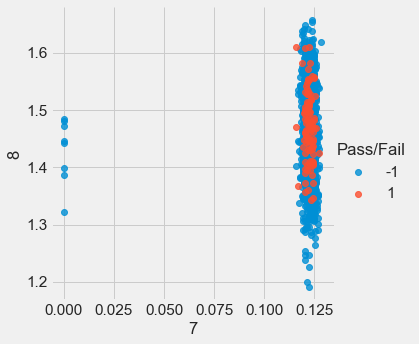

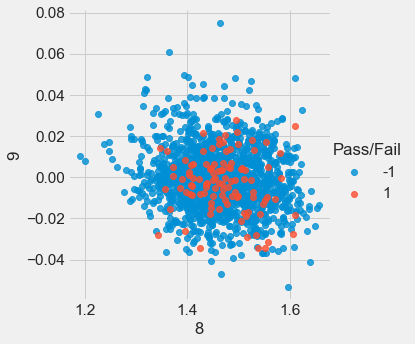

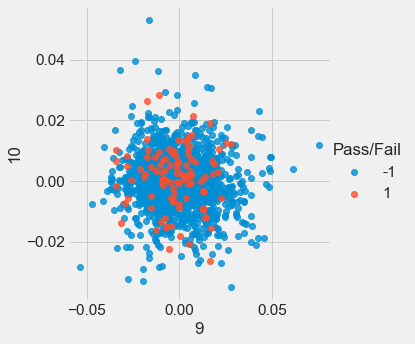

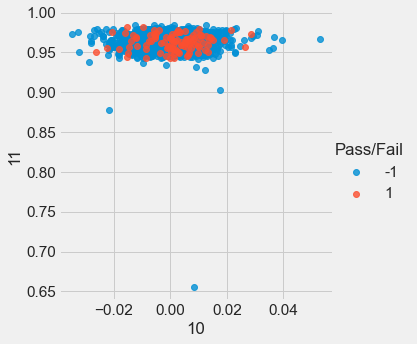

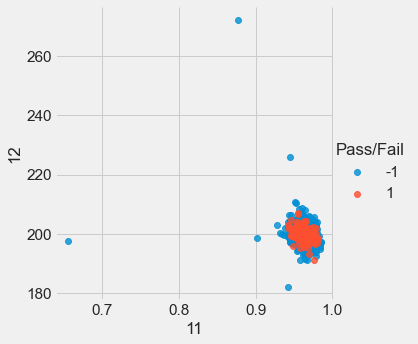

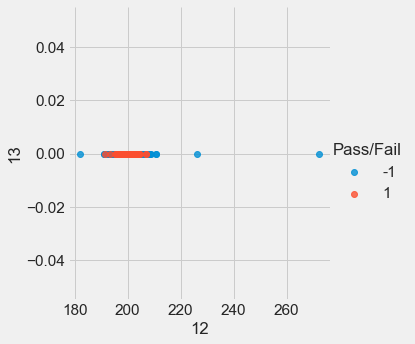

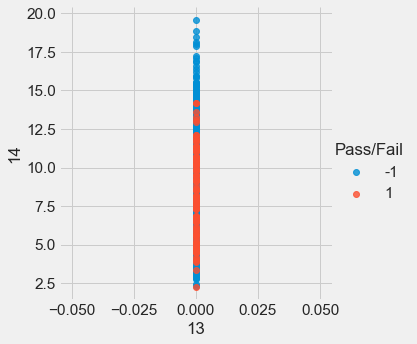

In [413]:
for i in range(2,14):
    sns.lmplot(""+str(i), ""+str(i+1), dft, hue="Pass/Fail", fit_reg=False);

###### Among the above models, 9 and 10 can be desirable as the pass rate is much more than other models between 1 to 14.

###### Q2 D - Check for multi-collinearity in the data and take necessary action. 

In [414]:
#Remove the highly collinear features from data

# Create correlation matrix
corr_matrix = dft.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Removing features with correlation greater than 70%
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
dft.drop(to_drop, axis=1, inplace=True)

### Data pre-processing

### Segregating predictors vs target attributes.

###### Q4 A - Segregate predictors vs target attributes.

In [415]:
x_data = dft.drop(['Pass/Fail'],axis=1) #Predictors
y_data = dft['Pass/Fail'] #Target Attributes

###### Q4 B - Check for target balancing and fix it if found imbalanced.

In [417]:
#performing train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data ,test_size = 0.2, shuffle=False)

In [418]:
y_train.value_counts()

-1    1166
 1      87
Name: Pass/Fail, dtype: int64

In [419]:
y_data.value_counts()

-1    1463
 1     104
Name: Pass/Fail, dtype: int64

In [420]:
#Target Balancing. The lowest we can go is 85
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE
ROS = RandomOverSampler(random_state=42)
x_ros, y_ros = ROS.fit_resample(x_data, y_data)
print('original dataset shape:', y_data.value_counts())
print('Resample dataset shape', y_ros.value_counts())

original dataset shape: -1    1463
 1     104
Name: Pass/Fail, dtype: int64
Resample dataset shape -1    1463
 1    1463
Name: Pass/Fail, dtype: int64


In [421]:
x_data.isna().sum()

0      0
1      0
2      0
3      0
4      0
      ..
582    0
583    0
586    0
587    0
589    0
Length: 385, dtype: int64

In [422]:
#using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x_data, y_data)

print('original dataset shape:', y_data.value_counts())
print('Resample dataset shape', y_ros.value_counts())

original dataset shape: -1    1463
 1     104
Name: Pass/Fail, dtype: int64
Resample dataset shape -1    1463
 1    1463
Name: Pass/Fail, dtype: int64


###### Q4 C - Perform train-test split and standardize the data or vice versa if required.

In [424]:
#Train test split is done. Standardising the data
#Standardising data using Linear Regression model
from sklearn import linear_model 
lrm = linear_model.LinearRegression()
lrm.fit(x_train, y_train)

LinearRegression()

###### In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [425]:
y_pred = lrm.predict(x_test)
y_pred

array([-8.45255452e-01, -7.71526807e-01, -4.78654018e-01, -8.15597008e-01,
       -3.50720374e-01, -1.15570005e+00, -5.12094377e-01, -5.39286948e-01,
       -7.30678992e-01, -7.21299825e-01, -8.18016253e-01, -1.43378630e+00,
       -8.62764470e-01, -9.77594506e-01, -5.35250758e-01, -1.42092633e+00,
       -8.36117104e-01, -1.52979674e+00, -7.34679174e-01, -8.03409238e-01,
       -1.26650088e+00, -9.59985264e-01, -7.55811997e-01, -1.03198533e+00,
       -1.23521549e+00, -1.00930862e+00, -1.34128902e+00, -7.22775484e-01,
       -6.11790569e-01, -7.27832395e-01, -8.63551877e-01, -1.29589669e+00,
       -1.00974740e+00, -1.26239014e+00, -1.24414046e+00, -1.06832419e+00,
       -8.87790563e-01, -1.20881322e+00, -1.66497693e+00, -7.03371829e-01,
       -7.69703844e-01, -9.95361756e-01, -1.21423042e+00, -1.18310603e+00,
       -6.78876595e-01, -7.06302984e-01, -1.05811028e+00, -9.52669290e-01,
       -9.89401762e-01, -8.13483326e-01, -7.78792258e-01, -4.25354826e+00,
       -1.28335214e+00, -

###### Q4 D - Check if the train and test data have similar statistical characteristics when compared with original data.

In [426]:
x_train.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1253.0,3014.368857,69.035495,2743.2400,2967.5400,3012.4500,3057.3100,3299.400000
1,1253.0,2495.215684,82.428893,2158.7500,2452.1000,2498.2800,2539.4700,2846.440000
2,1253.0,2200.319921,31.317068,2060.6600,2179.2000,2200.2000,2220.0445,2315.266700
3,1253.0,1389.057260,397.557659,847.7976,1072.8058,1298.8207,1622.3514,3715.041700
4,1253.0,1.313497,0.438310,0.6815,1.0177,1.2986,1.4869,4.197013
...,...,...,...,...,...,...,...,...
582,1253.0,0.500160,0.003526,0.4778,0.4979,0.5002,0.5025,0.509800
583,1253.0,0.015350,0.019073,0.0065,0.0114,0.0136,0.0163,0.476600
586,1253.0,0.021994,0.012638,-0.0042,0.0135,0.0210,0.0278,0.102800
587,1253.0,0.016040,0.008000,0.0032,0.0105,0.0144,0.0198,0.060700


In [427]:
x_data.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1567.0,3014.452896,73.480613,2743.2400,2966.66500,3011.8400,3056.54000,3356.3500
1,1567.0,2495.850231,80.227793,2158.7500,2452.88500,2498.9100,2538.74500,2846.4400
2,1567.0,2200.547318,29.380932,2060.6600,2181.09995,2200.9556,2218.05550,2315.2667
3,1567.0,1396.376627,439.712852,0.0000,1083.88580,1287.3538,1590.16990,3715.0417
4,1567.0,4.197013,56.103066,0.6815,1.01770,1.3171,1.52960,1114.5366
...,...,...,...,...,...,...,...,...
582,1567.0,0.500096,0.003403,0.4778,0.49790,0.5002,0.50235,0.5098
583,1567.0,0.015318,0.017174,0.0060,0.01160,0.0138,0.01650,0.4766
586,1567.0,0.021458,0.012354,-0.0169,0.01345,0.0205,0.02760,0.1028
587,1567.0,0.016475,0.008805,0.0032,0.01060,0.0148,0.02030,0.0799


In [428]:
y_train.describe().T

count    1253.000000
mean       -0.861133
std         0.508582
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        -1.000000
max         1.000000
Name: Pass/Fail, dtype: float64

In [429]:
y_data.describe().T

count    1567.000000
mean       -0.867262
std         0.498010
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        -1.000000
max         1.000000
Name: Pass/Fail, dtype: float64

###### Some of the test and the original data have somewhat similar characteristics. But after training the data, the values are drastically affected

### Model training, testing and tuning

###### Q5 A - Use any Supervised Learning technique to train a model. 

In [431]:
#Using SVM to train a model
from sklearn import svm
from sklearn import metrics
X= dft.drop(['Pass/Fail'], axis=1)
y= dft['Pass/Fail']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [432]:
train_test_split(y, shuffle=False)

[0      -1
 1      -1
 2       1
 3      -1
 4      -1
        ..
 1170   -1
 1171   -1
 1172   -1
 1173   -1
 1174   -1
 Name: Pass/Fail, Length: 1175, dtype: int64,
 1175   -1
 1176   -1
 1177   -1
 1178   -1
 1179   -1
        ..
 1562   -1
 1563   -1
 1564   -1
 1565   -1
 1566   -1
 Name: Pass/Fail, Length: 392, dtype: int64]

In [433]:
#Creating SVM
sv = svm.SVC(kernel='rbf')
sv.fit(X_train, y_train)

SVC()

###### In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [435]:
#Making prediction
y_predict = sv.predict(X_test)
print(y_predict)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

In [436]:
#Checking Accuracy of Prediction
print("Accuracy of the model is :",metrics.accuracy_score(y_test, y_predict))

Accuracy of the model is : 0.9382239382239382


###### Q5 B - Use cross validation techniques. 

In [437]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(sv, X, y, cv=5)
scores

array([0.93312102, 0.93312102, 0.93610224, 0.93290735, 0.93290735])

In [438]:
print("The model has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

The model has 0.93 accuracy with a standard deviation of 0.00


###### Q5 C - Apply hyper-parameter tuning techniques to get the best accuracy.

In [439]:
#using KNN and GridSearch CV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn= KNeighborsClassifier()
params = {
    'n_neighbors': [3,5,7,9,11,13],
    'weights': ['uniform', 'distance'],
    'p': [1,2]
}

clf = GridSearchCV(
    estimator=knn,
    param_grid=params,
    cv=5,
    n_jobs=5,
    verbose=1
)

In [440]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=5,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=1)

###### In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [441]:
print(clf.best_params_)

{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


###### Q5 D - Use any other technique/method which can enhance the model performance.

In [442]:
from scipy.stats import loguniform
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
model = LogisticRegression()
rcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
sp = dict()
sp['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
sp['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
sp['C'] = loguniform(1e-5, 100)
search = RandomizedSearchCV(model, sp, n_iter=1, scoring='accuracy', n_jobs=-1, cv=rcv, random_state=1)
res = search.fit(X, y)
print('The Best Score is : %s' % res.best_score_)
print('The Best Hyperparameters are: %s' % res.best_params_)

C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


The Best Score is : 0.9074636616037889
The Best Hyperparameters are: {'C': 0.008301451461243866, 'penalty': 'none', 'solver': 'newton-cg'}


C:\Users\dell\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [443]:
#Applying Random Projection
from sklearn import random_projection
X = np.random.rand(100, 10000)
transform = random_projection.GaussianRandomProjection()
X_new = transform.fit_transform(X)
X_new.shape

(100, 3947)

###### Q5 E - Display and explain the classification report in detail.

In [444]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.94      1.00      0.97       486
           1       0.00      0.00      0.00        32

    accuracy                           0.93       518
   macro avg       0.47      0.50      0.48       518
weighted avg       0.88      0.93      0.91       518



###### Q5 F - Apply the above steps for all possible models that you have learnt so far. 

In [448]:
dft

,0,1,2,3,4,5,6,7,8,9,...,570,571,572,573,582,583,586,587,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.500500,0.016200,...,533.8500,2.1113,8.95,0.3157,0.5005,0.0118,0.021458,0.016475,99.670066,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.496600,-0.000500,...,535.0164,2.4335,5.92,0.2653,0.5019,0.0223,0.009600,0.020100,208.204500,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.443600,0.004100,...,535.0245,2.0293,11.21,0.1882,0.4958,0.0157,0.058400,0.048400,82.860200,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.488200,-0.012400,...,530.5682,2.0253,9.33,0.1738,0.4990,0.0103,0.020200,0.014900,73.843200,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.503100,-0.003100,...,532.0155,2.0275,8.83,0.2224,0.4800,0.4766,0.020200,0.014900,73.843200,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.342400,-0.004500,...,536.3418,2.0153,7.98,0.2363,0.4988,0.0143,0.006800,0.013800,203.172000,-1
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.433300,-0.006100,...,537.9264,2.1814,5.48,0.3891,0.4975,0.0131,0.006800,0.013800,203.172000,-1
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,1.462862,-0.000841,...,530.3709,2.3435,6.49,0.4154,0.4987,0.0153,0.019700,0.008600,43.523100,-1
1565,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.462200,-0.007200,...,534.3936,1.9098,9.13,0.3669,0.5004,0.0178,0.026200,0.024500,93.494100,-1


In [452]:
# separating the dependent and independent data

x = dft.iloc[:,:386]
y = dft["Pass/Fail"]

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)

# splitting them into train test and split

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

# gettiing the shapes
print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of x: (1567, 386)
shape of y: (1567,)
shape of x_train:  (1096, 386)
shape of x_test:  (471, 386)
shape of y_train:  (1096,)
shape of y_test:  (471,)


### Scaling the data

In [453]:
# standardization

from sklearn.preprocessing import StandardScaler

# creating a standard scaler
sc = StandardScaler()

# fitting independent data to the model
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

### Random Forest Classifier (Normal Data)

In [454]:
model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

<AxesSubplot:>

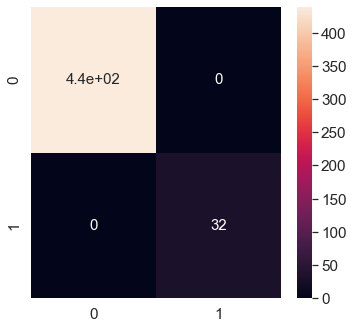

In [314]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [455]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  99.15074309978769


### Logistic Regression (Normal Data)

In [456]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train, y_train) 
y_pred = lr.predict(x_test)

<AxesSubplot:>

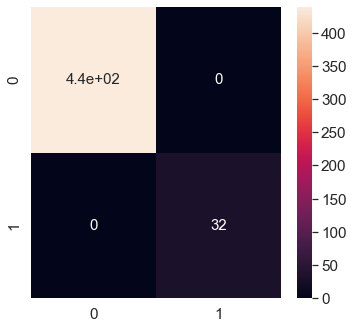

In [457]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [458]:
print("Accuracy: ", lr.score(x_test,y_test)*100)

Accuracy:  100.0


### Lasso (Normal Data)

In [459]:
lasso = Lasso(alpha=0.1,random_state=1)
lasso.fit(x_train,y_train)
#print ("Lasso model:", (lasso.coef_))

y_pred = lasso.predict(x_test)

#Convert the sign of the predicted values as the classifier
y_pred2 = np.sign(y_pred)

In [460]:
print("Accuracy: ", lasso.score(x_test,y_test)*100)

Accuracy:  95.92654152466838


<AxesSubplot:>

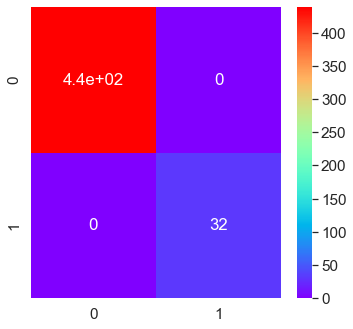

In [461]:
cm = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

### UnderSampling of the Dataset

In [467]:
# Under Sampling - Check how many failure observations are there
# We have 104 such observations

failed_tests = np.array(dft[dft['Pass/Fail'] == 1].index)
no_failed_tests = len(failed_tests)

print(no_failed_tests)

104


In [468]:
# Check how many pass observations are there
# We have 1,463 such observations

normal_indices = dft[dft['Pass/Fail'] == -1]
no_normal_indices = len(normal_indices)

print(no_normal_indices)

1463


In [469]:
# Get 104 random observations from the pass class as well

random_normal_indices = np.random.choice(no_normal_indices, size = no_failed_tests, replace = True)
random_normal_indices = np.array(random_normal_indices)

print(len(random_normal_indices))

104


In [470]:
#Getting a 50-50 representation from both pass and fail classes
under_sample = np.concatenate([failed_tests, random_normal_indices])
print(len(under_sample))

208


In [471]:
# creating the undersample data

undersample_data = dft.iloc[under_sample, :]

In [472]:
# splitting the undersample dataset into x and y sets

x = undersample_data.iloc[:, undersample_data.columns != 'Pass/Fail'] 
y = undersample_data.iloc[:, undersample_data.columns == 'Pass/Fail']

print(x.shape)
print(y.shape)

(208, 385)
(208, 1)


In [473]:
from sklearn.model_selection import train_test_split

x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_us.shape)
print(y_train_us.shape)
print(x_test_us.shape)
print(y_test_us.shape)

(145, 385)
(145, 1)
(63, 385)
(63, 1)


### Using PCA for demensionality reduction

In [474]:
# standardization

sc = StandardScaler()
x_train_us = sc.fit_transform(x_train_us)
x_test_us = sc.transform(x_test_us)

In [475]:
#Scaling the data before applying PCA
from scipy.stats import zscore
data_new=dft.iloc[:,:202].apply(zscore)
data_new.head()

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,221,222,223,224,225
0,0.224309,0.849725,-0.436273,0.033555,-0.050580,NaN,-0.563790,0.266269,0.509826,1.128417,...,-0.962989,-2.088725,0.911829,-0.250122,-1.375019,0.428472,0.219582,0.949805,-0.398037,2.111519
1,1.107136,-0.382910,1.017137,0.153067,-0.060045,NaN,0.198217,0.322244,0.456999,0.022582,...,0.583725,-0.394536,0.066749,0.159303,1.065100,0.660254,-0.132713,0.101235,-0.508006,2.223278
2,-1.114158,0.799102,-0.481289,0.686213,-0.047906,NaN,-0.906210,0.255074,-0.260907,0.327183,...,0.096858,-1.900916,0.003585,-1.149763,-1.131007,1.527289,0.114073,1.081806,-0.442310,-0.472988
3,-0.350312,-0.198875,-0.051547,-1.106948,-0.051290,NaN,0.503246,-0.013602,0.343218,-0.765408,...,-0.187976,-0.750590,0.469687,1.511799,-0.581980,0.673130,-0.130925,0.530337,-0.029570,-0.518068
4,0.242143,0.087526,1.117387,-0.158919,-0.047492,NaN,-0.115382,0.187905,0.545044,-0.149584,...,0.782446,0.348872,0.650464,0.309770,-0.154959,0.836236,-0.150596,-0.973833,1.965583,0.857771


In [476]:
data_new.isnull().any().any()

True

In [477]:
data_new = data_new.replace(np.NaN, 0)

In [478]:
data_new.isnull().any().any()

False

In [479]:
# separating the dependent and independent data

x = data_new.iloc[:,:386]
y = dft["Pass/Fail"]

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (1567, 202)
shape of y: (1567,)


In [480]:
# PCA
# Step 1 - Create covariance matrix

cov_matrix = np.cov(x.T)
print('Covariance Matrix \n%s', cov_matrix)

Covariance Matrix 
%s [[ 1.00063857 -0.14393166  0.00475868 ... -0.02316155 -0.01394332
  -0.01531   ]
 [-0.14393166  1.00063857  0.00577089 ... -0.02109423  0.02184952
   0.038789  ]
 [ 0.00475868  0.00577089  1.00063857 ...  0.01645842  0.05162139
   0.04759353]
 ...
 [-0.02316155 -0.02109423  0.01645842 ...  1.00063857 -0.01431929
   0.06121441]
 [-0.01394332  0.02184952  0.05162139 ... -0.01431929  1.00063857
   0.02234804]
 [-0.01531     0.038789    0.04759353 ...  0.06121441  0.02234804
   1.00063857]]


In [481]:
# Step 2- Get eigen values and eigen vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s', eig_vecs)
print('\n Eigen Values \n%s', eig_vals)

Eigen Vectors 
%s [[-0.01270545 -0.03346473 -0.035192   ...  0.          0.
   0.        ]
 [ 0.00080899  0.01006074  0.00453265 ...  0.          0.
   0.        ]
 [-0.00460056  0.00709694  0.02667192 ...  0.          0.
   0.        ]
 ...
 [-0.00496116 -0.0136494  -0.01695281 ...  0.          0.
   0.        ]
 [ 0.00720869  0.01068562  0.02828399 ...  0.          0.
   0.        ]
 [-0.00333943  0.01890308  0.01528052 ...  0.          0.
   0.        ]]

 Eigen Values 
%s [1.04096519e+01 7.29067867e+00 6.86950635e+00 5.47950544e+00
 4.24201816e+00 3.88963927e+00 3.65247091e+00 3.48995343e+00
 3.30354200e+00 3.24570110e+00 3.11818412e+00 2.93702598e+00
 2.77377878e+00 2.63359462e+00 2.49954386e+00 2.46172631e+00
 2.40220577e+00 2.33108379e+00 2.20274707e+00 2.09041289e+00
 2.04363282e+00 1.98573352e+00 1.95616095e+00 1.90523388e+00
 1.89046118e+00 1.87913079e+00 1.85990019e+00 1.82897883e+00
 1.77966557e+00 1.72404317e+00 1.69707073e+00 1.66750523e+00
 1.63936784e+00 1.59297978e+00 

In [482]:
tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)

Cumulative Variance Explained [  5.65380917   9.61360593  13.34465077  16.32074241  18.62471582
  20.73730117  22.72107293  24.61657634  26.41083384  28.17367613
  29.86725994  31.46245107  32.96897751  34.39936553  35.75694637
  37.09398731  38.39870077  39.66478565  40.86116683  41.99653577
  43.10649699  44.18501128  45.24746379  46.2822562   47.30902508
  48.32964008  49.33981034  50.33318623  51.29977855  52.23616059
  53.15789305  54.06356755  54.95395976  55.81915715  56.66736458
  57.50218713  58.32081164  59.12317494  59.90712474  60.68652084
  61.45303838  62.19979879  62.9360253   63.65725444  64.36472333
  65.06405095  65.74818626  66.41837139  67.07649807  67.71775982
  68.35425395  68.98257923  69.60235034  70.21218797  70.80827686
  71.40157694  71.97912716  72.55405028  73.12531652  73.68590407
  74.23523635  74.78284684  75.31644609  75.83945709  76.36120234
  76.87044     77.37420241  77.87004042  78.35835422  78.84477064
  79.32280585  79.79227873  80.25763836  80.71

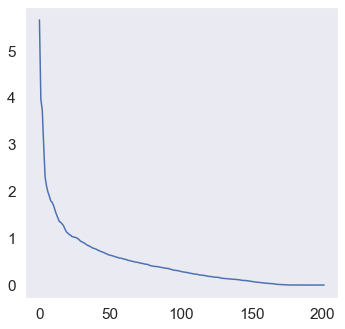

In [483]:
plt.plot(var_exp)

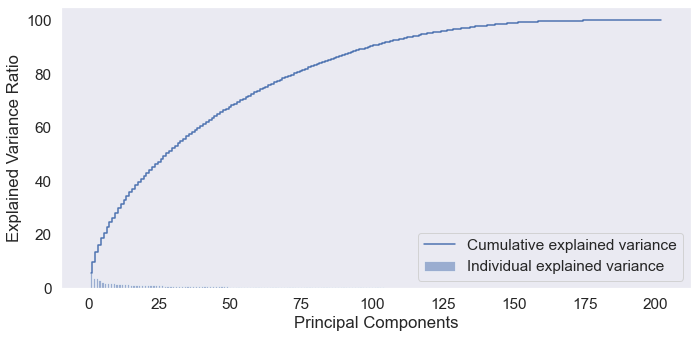

In [484]:
# Ploting 
plt.figure(figsize=(10 , 5))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [485]:
len(cum_var_exp)

202

In [491]:
# Using scikit learn PCA here. It does all the above steps and maps data to PCA dimensions in one shot
from sklearn.decomposition import PCA

# NOTE - we are generating only 130 PCA dimensions (dimensionality reduction from 202 to 78)
# For 130 components we are getting approximately 90% of the variance
pca = PCA(n_components=140)
data_reduced = pca.fit_transform(x)
data_reduced.transpose()

array([[-1.6304965 , -1.88404005,  0.43534914, ..., -0.97158695,
        -0.7835588 ,  1.40276571],
       [ 3.6919747 ,  1.57020425, -0.71713836, ...,  0.04357249,
        -3.44157861, -4.23304352],
       [-0.05186245,  0.16561078, -2.38121521, ...,  2.38777318,
        -1.18616732, -1.61464664],
       ...,
       [-0.88013534, -0.32787601,  0.33236885, ..., -0.46072315,
         0.19960409, -0.47419904],
       [ 0.07827194,  0.50845418, -0.32954279, ...,  0.85730391,
         0.53120113,  0.0940114 ],
       [ 0.15126889, -0.05765746, -0.55492104, ...,  0.38642641,
         0.04361797, -0.1706995 ]])

In [492]:
pca.components_

array([[-0.01270545,  0.00080899, -0.00460056, ..., -0.00496116,
         0.00720869, -0.00333943],
       [-0.03346473,  0.01006074,  0.00709694, ..., -0.0136494 ,
         0.01068562,  0.01890308],
       [ 0.035192  , -0.00453265, -0.02667192, ...,  0.01695281,
        -0.02828399, -0.01528052],
       ...,
       [-0.00404136,  0.02870195, -0.02282654, ..., -0.14112423,
        -0.10299647,  0.04585021],
       [-0.04932059, -0.02676997, -0.04807823, ..., -0.00921085,
         0.12468331,  0.02343446],
       [ 0.00939086,  0.0351408 , -0.00804854, ...,  0.07809169,
         0.05208958, -0.00674917]])

In [493]:
df_comp = pd.DataFrame(pca.components_,columns=list(x))
df_comp.head()

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,221,222,223,224,225
0,-0.012705,0.000809,-0.004601,-0.001867,0.003572,-5.421011e-20,0.006666,0.001864,-0.007476,-0.011438,...,0.010107,-0.010934,0.005814,-0.003911,0.006331,0.008138,-0.000976,-0.004961,0.007209,-0.003339
1,-0.033465,0.010061,0.007097,-0.049454,-0.026823,0.000000e+00,0.055143,0.024209,0.061280,-0.024962,...,-0.033659,0.013642,-0.032459,0.025979,-0.009544,0.028582,0.017086,-0.013649,0.010686,0.018903
2,0.035192,-0.004533,-0.026672,0.068593,-0.000621,-1.110223e-16,-0.078002,0.001385,-0.042288,0.033445,...,-0.009461,0.023561,-0.066506,-0.007781,-0.035631,-0.011194,-0.015756,0.016953,-0.028284,-0.015281
3,-0.007565,0.032036,0.026358,0.044949,0.020211,-1.110223e-16,-0.050751,-0.016329,-0.024372,0.006165,...,-0.015495,-0.010209,-0.014738,-0.041461,0.021378,0.034771,-0.022076,-0.005233,0.069779,-0.002018
4,0.000075,-0.000810,-0.011484,0.005823,0.020693,-9.801188e-17,-0.022739,-0.035914,0.038145,-0.001189,...,0.040550,0.007776,-0.021795,0.016473,-0.012332,-0.003638,0.005847,0.003967,0.050721,-0.000614


<AxesSubplot:>

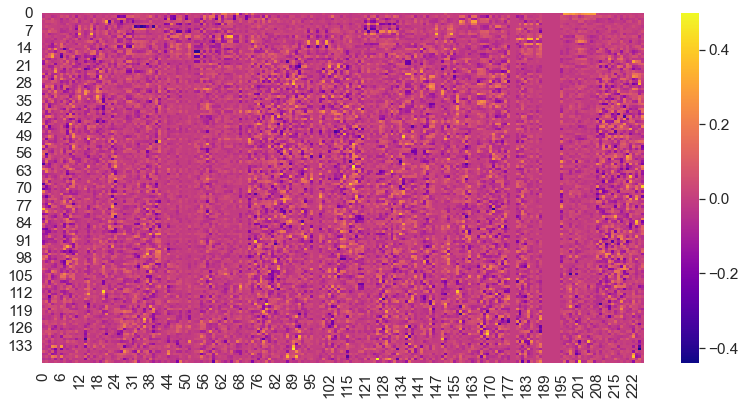

In [494]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

In [495]:
data_reduced.shape

(1567, 140)

In [496]:
df_red2 = pd.DataFrame(data_reduced)
df_red2.head()


,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,-1.630496,3.691975,-0.051862,-0.668705,-2.077835,1.135448,-0.668645,0.314671,1.640011,0.821176,...,-0.304584,1.652499,-0.428638,-0.072745,0.011604,-0.077215,-0.200534,-0.880135,0.078272,0.151269
1,-1.884040,1.570204,0.165611,-0.147248,-2.368733,0.895899,-0.610303,1.660127,0.992568,2.028204,...,-0.964033,0.515650,-0.305080,-0.126979,0.918275,-0.626807,-0.293562,-0.327876,0.508454,-0.057657
2,0.435349,-0.717138,-2.381215,-0.143110,-2.659539,-0.003565,0.199635,-0.298146,2.351148,-0.012917,...,-0.107764,0.214938,0.682522,0.106986,-0.142718,1.534241,-0.002483,0.332369,-0.329543,-0.554921
3,0.540502,0.017672,-2.427204,1.446743,-2.387545,2.175058,4.023031,-2.276916,-1.465059,0.108208,...,-0.404098,0.356980,0.823340,0.773697,0.388864,0.533263,0.068545,0.197575,1.056476,-0.026764
4,2.379029,-3.082285,-6.176974,0.649050,0.748155,0.183766,-1.214315,1.372647,-1.691736,4.538218,...,-0.042637,-0.904546,0.141388,-0.160377,-0.267213,-0.180793,0.357680,-0.431102,-0.020018,0.337825


###### The model with SVM has the highest accuracy of 93%. According to my knowledge, the SVM model has the highest accuracy and should be the final best model. The dataset contains a large number of values. Because there is only one categorical variable, Pass/Fail, multiple models can be trained and tested. However, the models correctly predicted which columns have pass values among all the other columns.